https://www.pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/

In [1]:
# !pip install imutils
!pip install opencv-python opencv-contrib-python

     |████████████████████████████████| 57.4 MB 45.6 MB/s 


In [2]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
# from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
# from tensorflow.python.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.python.keras.models import Model, load_model
# from tensorflow.python.keras.utils import multi_gpu_model, plot_model ,Sequence
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp
import os
from glob import glob  # for getting list paths of image and labels
from random import choice,sample
from matplotlib import pyplot as plt
import cv2 # saving and loading images

In [3]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    # using sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model
model1 = Unet(224 , 224 , 34)
model1.load_weights('../input/background-removal/top-weights.h5')

model2 = Unet(224 , 224 , 34)
model2.load_weights('../input/smooth-blobs/model.h3')

In [4]:
def selective_search(image, method="fast"):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()
	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()
	# run selective search on the input image
	rects = ss.process()
	# return the region proposal bounding boxes
	return rects

In [5]:
im_size = 2500

In [6]:
from keras.models import Model
from keras.layers import Input,Lambda,merge
from keras.layers import Conv2D,Cropping2D,Average
from keras.layers import MaxPooling2D
from keras.utils import plot_model
from keras import backend as K
import keras
base = Input(shape=(im_size, im_size, 3))

mask = tf.keras.layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(base)


rmodel = Unet(224 , 224 , 34)
rmodel.load_weights('../input/background-removal/top-weights.h5')
rmodel.trainable=False
mask = rmodel(mask)
mask = tf.keras.layers.experimental.preprocessing.Resizing(im_size, im_size, interpolation="bilinear")(mask)
    
mask = Lambda(lambda w:  K.round(w))(mask)  #
x = keras.layers.Multiply()([base, mask])  #

model = Model(base,x)


(1, 2500, 2500, 3)
(224, 224, 1)


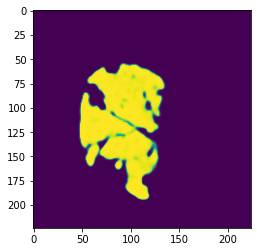

In [7]:
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
p = "../input/pp21fire/data/data/"
img = img_to_array(load_img("../input/plant-pathology-2021-fgvc8/test_images/c7b03e718489f3ca.jpg",target_size=(im_size,im_size,3)))
img = np.expand_dims(img,axis=0)/255.
img = model.predict(img)
print(img.shape)
img0 = cv2.resize(img[0], (224, 224))

img0[np.where((img0==[0,0,0]).all(axis=2))] = [0,1,0];

img0 = np.expand_dims(img0,axis=0)

mask0 = model2.predict(img0)[0]
print(mask0.shape)
img = img[0]
H,W,_= img.shape
plt.imshow(mask0)

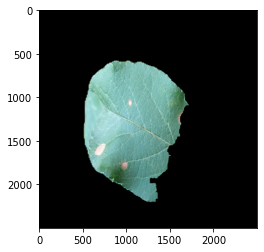

In [8]:
plt.imshow(img)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
1
48 55 87 140
0.9999969


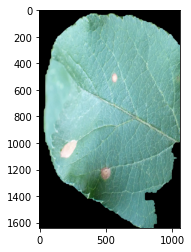

In [9]:
%time
mask = mask0.copy()
mask[np.where((mask>0.5).all(axis=2))] = 255;
mask[np.where((mask<0.5).all(axis=2))] = 0;
inter = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
inter = cv2.cvtColor(inter,cv2.COLOR_BGR2GRAY)
inter = inter.astype(np.uint8)


cnts, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(cnts))


cnt = cnts[0]
x,y,w,h = cv2.boundingRect(cnt)
print(x,y,w,h)
print(mask0.max())
mask_resized = cv2.resize(np.uint8(mask0*255),(W,H))
mask_resized = mask_resized != 0
# segment = np.zeros((H,W,3))
# segment[:,:,0] = img[:,:,0]*mask_resized
# segment[:,:,1] = img[:,:,1]*mask_resized
# segment[:,:,2] = img[:,:,2]*mask_resized
# segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]

a,b = W//224,H//224
x,y,w,h = int(x*a)-50,int(y*b)-50,int(w*a)+100,int(h*b)+100
roi = img[y:y + h, x:x + w]

plt.imshow(roi)

In [10]:
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
# print(train[train.labels==a[5]])
# a = ['powdery_mildew', 'rust', 'healthy', 'complex', 'scab', 'frog_eye_leaf_spot']
a = ['rust', 'complex', 'frog_eye_leaf_spot']
xx = os.listdir('../input/pp21fire/data/data')
train["ok"] = train.image.apply(lambda e:e in xx)
train =train[train.ok == True]
train["ok"] = train.labels.apply(lambda e:e in a)
train =train[train.ok == True]
# print(train)
# print(train[train.labels==a[0]])
L = []
for i in a:
    for j in train[train.labels==i].image.values[:50]:
        L.append([i,j])

In [11]:
print(set(train.labels))

{'rust', 'frog_eye_leaf_spot', 'complex'}


In [12]:
# %time
# !mkdir rois
# from tqdm import tqdm
# k=0

# for it in tqdm(L):
#     l,i=it
#     j = '../input/pp21fire/data/data/'+i
#     img0 = img_to_array(load_img(j,target_size=(im_size,im_size,3)))
#     img[np.where((img==[0,0,0]).all(axis=2))] = [0,1,0];
#     img = cv2.resize(img0, (224, 224))
#     img = np.expand_dims(img,axis=0)/255.
#     mask0 = model2.predict(img)[0]
# #     print(mask0.shape)
#     img = img[0]
#     H,W,_= img0.shape
    
    
    
#     # Part two
#     mask = mask0.copy()
#     mask[np.where((mask>0.5).all(axis=2))] = 255;
#     mask[np.where((mask<0.5).all(axis=2))] = 0;
#     inter = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
#     inter = cv2.cvtColor(inter,cv2.COLOR_BGR2GRAY)
#     inter = inter.astype(np.uint8)
    
#     cnts, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     print(len(cnts))
#     for cnt in cnts:
#         x,y,w,h = cv2.boundingRect(cnt)
#         mask_resized = cv2.resize(np.uint8(mask0*255),(W,H))
#         mask_resized = mask_resized != 0
# #         segment = np.zeros((H,W,3))
# #         segment[:,:,0] = img0[:,:,0]*mask_resized
# #         segment[:,:,1] = img0[:,:,1]*mask_resized
# #         segment[:,:,2] = img0[:,:,2]*mask_resized
# #         segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]

#         a,b = W//224,H//224
#         try:
#             x,y,w,h = int(x*a)-100,int(y*b)-100,int(w*a)+200,int(h*b)+200
#             roi = img0[y:y + h, x:x + w]
#             cv2.imwrite("rois/%s-%d.jpg"%(l,k),roi)
#             k+=1
#         except:pass
# #         break
# #     plt.imshow(inter)
# #     break

In [13]:
# @ Generate masked
!mkdir masked
from tqdm import tqdm
for i in tqdm(list(train.image.values)):
    j = '../input/pp21fire/data/data/'+i
    img = img_to_array(load_img(j,target_size=(im_size,im_size,3)))
    img = np.expand_dims(img,axis=0)/255.
    img = model.predict(img)
#     print(img.shape)

    image = img[0].copy()

    image[np.where((image==[0,0,0]).all(axis=2))] = [0,1,0];
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (25,0,0), (160,255,255))
    mask = 255-mask
    blur = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)/255
#     plt.imshow(blur)
    cv2.imwrite("masked/"+i,blur)


100%|██████████| 1500/1500 [29:18<00:00,  1.17s/it]


In [14]:

# from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
# p = "../input/pp21fire/data/data/"
# img = img_to_array(load_img("../input/plant-pathology-2021-fgvc8/train_images/fff00006af9e9c38.jpg",target_size=(im_size,im_size,3)))
# img = np.expand_dims(img,axis=0)/255.
# img = model.predict(img)
# print(img.shape)

# image = img[0].copy()

# image[np.where((image==[0,0,0]).all(axis=2))] = [0,1,0];
# hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# mask = cv2.inRange(hsv, (25,0,0), (160,255,255))
# mask = 255-mask
# blur = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)/255

# f = cv2.bitwise_or(image, image, mask=mask)
# plt.imshow(f)

In [15]:
# plt.imshow(image)

In [16]:
# %%time
# rects = selective_search(blur)
# print(len(rects))

In [17]:
# proposals = []
# boxes = []
# W,H = im_size,im_size
# clone = image.copy()
# ok = 1
# for (x1, y1, w1, h1) in rects:
#     x, y, w, h = x1*10, y1*10, w1*10, h1*10
# #     print(x,y)
#     roi = image[y:y + h, x:x + w]
#     croi = blur[y1:y1 + h1, x1:x1 + w1]
#     roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
#     roi = cv2.resize(roi, (100, 100))
#     if roi[0,0,0]==0 or  roi[-1,0,0]==0 or roi[0,-1,0]==0 or roi[-1,-1,0]==0 or w>W/4 or h>H/4 or abs((w/h)-0.5)>0.5:continue
#     proposals.append(roi)
#     boxes.append((x, y, w, h))
#     startX, startY,endX, endY = x,y,x+w,y+h
#     cv2.rectangle(clone, (startX, startY), (endX, endY),
#             (0, 255, 0), 2)

# plt.imshow(clone)

# print(len(boxes))
# proposals = np.array(proposals)
# print("[INFO] proposal shape: {}".format(proposals.shape))


In [18]:
# plt.imshow(proposals[5])

In [19]:
# train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
# a = ['powdery_mildew', 'rust', 'healthy', 'complex', 'scab', 'frog_eye_leaf_spot']
# print(train[train.labels==a[0]].labels.values)

# data = {i:[] for i in a}
# data["info"]="Image size %d*%dpx"%(im_size,im_size)
# print(data)

In [20]:
# print(train[train.labels=="frog_eye_leaf_spot"])

In [21]:
# for label in a:
#     print(label)
#     images_path = train[train.labels==label].image.values

In [22]:
# path = "../input/plant-pathology-2021-fgvc8/train_images/"
# labels =[]
# k =0
# !mkdir blobs
# for label in a:
#     print(label)
#     images_path = train[train.labels==label].image.values
#     for im in images_path:
#         # Part One
#         img = img_to_array(load_img(path+im,target_size=(im_size,im_size,3)))
#         img = np.expand_dims(img,axis=0)/255.
#         img = model.predict(img)

#         low_green = np.array([30, 30, 0])/255
#         high_green = np.array([104, 153, 70])/255
#         image = img[0].copy()

#         image[np.where((image==[0,0,0]).all(axis=2))] = [0,1,0];

#         hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#         mask = cv2.inRange(hsv, (90, 0, 0), (160, 255,255))
#         mask = cv2.blur(mask,(100,100))
#         mask = cv2.resize(mask, (250, 250))
#         mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
        
#         # Part Two
#         rects = selective_search(mask)
        
#         # Part Three

#         W,H = im_size,im_size
#         clone = image.copy()
#         for (x1, y1, w1, h1) in rects[:20]:
#             x, y, w, h = x1*10, y1*10, w1*10, h1*10
#             roi = image[y:y + h, x:x + w]
#             croi = blur[y1:y1 + h1, x1:x1 + w1]
#             roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
#             roi = cv2.resize(roi, (100, 100))
#             if roi[0,0,0]==0 or  roi[-1,0,0]==0 or roi[0,-1,0]==0 or roi[-1,-1,0]==0 or w>W/4 or h>H/4 or abs((w/h)-0.5)>0.5:continue
# #             proposals.append(roi)
#             boxes.append((x, y, w, h))
#             startX, startY,endX, endY = x,y,x+w,y+h
#             cv2.rectangle(clone, (startX, startY), (endX, endY),
#                     (0, 255, 0), 2)
#             cv2.imwrite("blobs/%d.jpg"%k,roi*255)
#             labels.append(label)
#             k+=1


In [23]:
# print(labels )


In [24]:
# import pickle

# with open("labels.pickle", "wb") as f:
#     pickle.dump(labels, f)

In [25]:
# !apt install zip


In [26]:
!zip -r masked.zip masked 
!rm masked -r

  adding: masked/ (stored 0%)
  adding: masked/95b80762eec6193e.jpg (deflated 98%)
  adding: masked/96cccdd84fd54542.jpg (deflated 95%)
  adding: masked/aa91d21a93664fcd.jpg (deflated 93%)
  adding: masked/93863bb5a1eb4469.jpg (deflated 88%)
  adding: masked/9ee390fd18622795.jpg (deflated 98%)
  adding: masked/859eaef03a575924.jpg (deflated 93%)
  adding: masked/95c71dc0cffa050e.jpg (deflated 98%)
  adding: masked/99d03881b7d7d23c.jpg (deflated 98%)
  adding: masked/8b9274cb3409f27d.jpg (deflated 99%)
  adding: masked/a846c2c24bc6dbdd.jpg (deflated 93%)
  adding: masked/9a969343e96d6169.jpg (deflated 97%)
  adding: masked/923ccbd2071dead1.jpg (deflated 88%)
  adding: masked/818a4bcfdb78385c.jpg (deflated 98%)
  adding: masked/86cc74546eb9d92c.jpg (deflated 93%)
  adding: masked/84eb76e5ba1e3124.jpg (deflated 94%)
  adding: masked/8bda9c2d9129d91d.jpg (deflated 98%)
  adding: masked/809106ca5fc7735f.jpg (deflated 98%)
  adding: masked/a295c76ace225ccb.jpg (deflated 98%)
  adding: masked